In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
reviewdf= pd.read_csv("/content/drive/MyDrive/video_game_reviews.csv")

In [5]:
reviewdf['review'] = reviewdf['review'].astype(str)

In [6]:
reviewdf['word_count'] = reviewdf['review'].str.split().str.len()
reviewdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26652 entries, 0 to 26651
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26652 non-null  int64 
 1   review         26652 non-null  object
 2   review_rating  26652 non-null  int64 
 3   word_count     26652 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 833.0+ KB


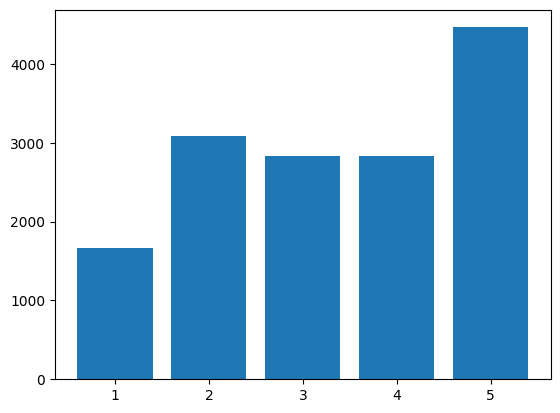

In [7]:
plt.bar(reviewdf['review_rating'],reviewdf['word_count'])
plt.show()

In [ ]:
!pip install -U transformers

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

Device set to use cpu


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

In [ ]:
reviewdf['sentiment'] = reviewdf['review'].apply(distilled_student_sentiment_classifier)


Token indices sequence length is longer than the specified maximum sequence length for this model (1360 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (1360) must match the size of tensor b (512) at non-singleton dimension 1

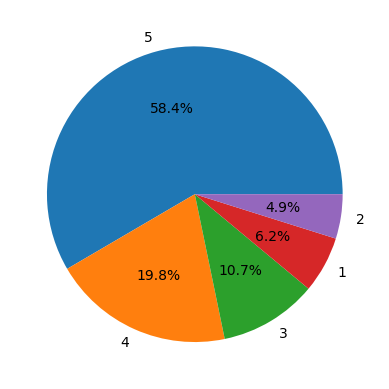

In [ ]:
plt.pie(reviewdf['review_rating'].value_counts().values,
        labels = reviewdf['review_rating'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

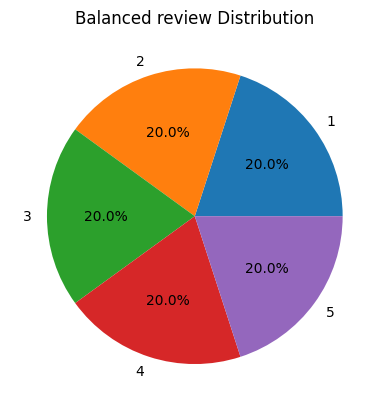

In [ ]:
star1 = reviewdf[reviewdf['review_rating'] == 1].sample(n=1000, random_state=42)
star2 = reviewdf[reviewdf['review_rating'] == 2].sample(n=1000, random_state=42)
star3 = reviewdf[reviewdf['review_rating'] == 3].sample(n=1000, random_state=42)
star4 = reviewdf[reviewdf['review_rating'] == 4].sample(n=1000, random_state=42)
star5 = reviewdf[reviewdf['review_rating'] == 5].sample(n=1000, random_state=42)
balanced_df = pd.concat([star1, star2, star3, star4, star5], axis=0)

# Visualize the balanced distribution
plt.pie(balanced_df['review_rating'].value_counts().values,
        labels=balanced_df['review_rating'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Balanced review Distribution")
plt.show()

In [ ]:

import string
reviewdf['review'] = reviewdf['review'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

reviewdf['review']= reviewdf['review'].apply(lambda x: remove_punctuations(x))
reviewdf.head()

,id,review,review_rating,word_count
0,1,1st shipment received a book instead of the ga...,1,53
1,2,i still havent figured this one out did everyt...,2,80
2,3,i bought this and the key didnt work it was a...,1,37
3,4,i love it use it all the time really works per...,5,20
4,5,my grandkids and their parents love playing wi...,5,37


In [ ]:
reviewdf.head()

,id,review,review_rating,word_count
0,1,1st shipment received a book instead of the ga...,1,53
1,2,i still havent figured this one out did everyt...,2,80
2,3,i bought this and the key didnt work it was a...,1,37
3,4,i love it use it all the time really works per...,5,20
4,5,my grandkids and their parents love playing wi...,5,37


In [ ]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

balanced_df['review'] = balanced_df['review'].apply(preprocess_text)

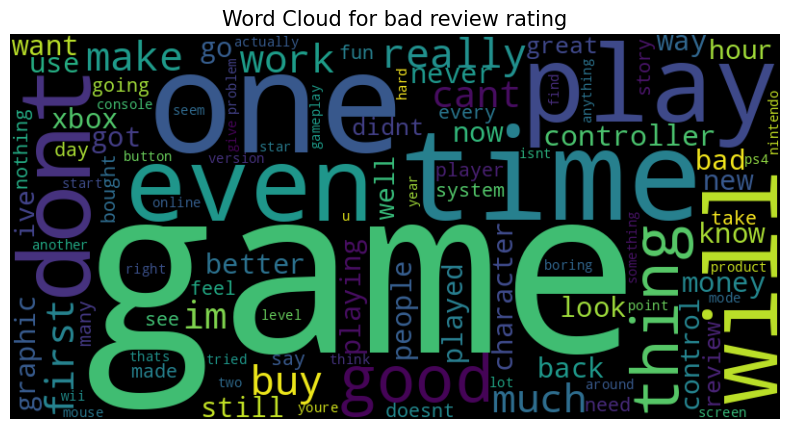

In [ ]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['review'])
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} review rating", fontsize=15)
    plt.show()

plot_word_cloud(reviewdf[reviewdf['review_rating'] == 1], typ="bad")

In [ ]:
features = reviewdf['review']
target = reviewdf['review_rating']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
## do tokenization, text classification, init rnn, etc

Sort rating into helpful or harmful, id phrases  and tone